# DiploDatos Kaggle Competition

Grupo 15:
- Fassi, Carolina Noelia.
- Fassi, Angel Maximiliano.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context('talk')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report , plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier

# Analisis exploratorio e imputacion de datos faltantes.

---



In [3]:
#Cargamos los datos del set train y test para realizarles el tratamiento de manera simultanea.
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print(train_df.shape,test_df.shape)
y = train_df.Transported

(7823, 14) (870, 13)


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7823 entries, 0 to 7822
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   7823 non-null   int64  
 1   HomePlanet    7644 non-null   object 
 2   CryoSleep     7823 non-null   bool   
 3   Cabin         7640 non-null   object 
 4   Destination   7663 non-null   object 
 5   Age           7823 non-null   float64
 6   VIP           7823 non-null   bool   
 7   RoomService   7669 non-null   float64
 8   FoodCourt     7668 non-null   float64
 9   ShoppingMall  7635 non-null   float64
 10  Spa           7665 non-null   float64
 11  VRDeck        7654 non-null   float64
 12  Name          7645 non-null   object 
 13  Transported   7823 non-null   int64  
 14  CabinPiso     7823 non-null   object 
 15  CabinNumero   7823 non-null   float64
 16  CabinLado     7823 non-null   object 
dtypes: bool(2), float64(7), int64(2), object(6)
memory usage: 932.2+ KB


In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870 entries, 0 to 869
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   870 non-null    int64  
 1   HomePlanet    848 non-null    object 
 2   CryoSleep     870 non-null    bool   
 3   Cabin         856 non-null    object 
 4   Destination   850 non-null    object 
 5   Age           870 non-null    float64
 6   VIP           870 non-null    bool   
 7   RoomService   843 non-null    float64
 8   FoodCourt     842 non-null    float64
 9   ShoppingMall  850 non-null    float64
 10  Spa           845 non-null    float64
 11  VRDeck        851 non-null    float64
 12  Name          854 non-null    object 
 13  CabinPiso     870 non-null    object 
 14  CabinNumero   870 non-null    float64
 15  CabinLado     870 non-null    object 
dtypes: bool(2), float64(7), int64(1), object(6)
memory usage: 97.0+ KB


In [6]:
# La variable VIP, tiene muy pocos casos True en relacion a los False (por definicion de VIP)
# Consideramos tambien que seria mas probable que se pierdan registros de un pasajero No VIP.
# Por lo tanto los imputaremos todos los faltantes como False.
print(train_df.VIP.value_counts())
train_df['VIP']=train_df['VIP'].fillna(value=False)
test_df['VIP']=test_df['VIP'].fillna(value=False)

False    7640
True      183
Name: VIP, dtype: int64


In [7]:
# Separamos la variable compuesta por el Piso, Numero y Lado de la cabina.
def separar(t_data):
  X = t_data
  X['CabinPiso']=X.Cabin.str.split('/', expand=True)[0]
  X['CabinPiso']=X['CabinPiso'].fillna(value='U') #Los valores faltantes los consideramos desconocidos.

  X['CabinNumero']=X.Cabin.str.split('/', expand=True)[1]
  X['CabinNumero']=X['CabinNumero']

  X['CabinLado']=X.Cabin.str.split('/', expand=True)[2]
  X['CabinLado']=X['CabinLado'].fillna(value='U') #Los valores faltantes los consideramos desconocidos.

  X[['CabinNumero']] = X[['CabinNumero']].astype(float)
  X[['CabinNumero']] = X[['CabinNumero']].fillna(0.0) #Los valores faltantes los consideramos 0.


  return X
train_df= separar(train_df)
test_df= separar(test_df)

In [8]:
# Para la variable Age, imputamos con la mediana para datos faltantes.
def impAge(t_data):
  X=t_data
  X['Age']=X['Age'].fillna(value=X.Age.median())
  return X
train_df= impAge(train_df)
test_df= impAge(test_df)

In [9]:
# Para la variable CryoSleep imputammos considerando simultaneamente todas las columnas de gastos.
# Alguien que haya realizado gastos durante el viaje sera CryoSleep= False.
def impCryo(t_data):
  X=t_data
  var=(X.RoomService==0) & (X.FoodCourt==0) & (X.ShoppingMall==0) & (X.Spa==0) & (X.VRDeck==0)
  X[(X.CryoSleep.isnull()) & (var==True)]=X[(X.CryoSleep.isnull()) & (var==True)].fillna(value=True)
  X.CryoSleep=X.CryoSleep.fillna(value=False)
  return X
train_df= impCryo(train_df)
test_df= impCryo(test_df)

In [13]:
# Utilizamos la imputacion con la mediana para todas las variables monetarias.
def impMon(t_data):
  X=t_data
  imputer_cols = ["FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
  imputer = SimpleImputer(strategy="median")
  X[imputer_cols] = imputer.fit_transform(X[imputer_cols])
  return X
train_df= impMon(train_df)
test_df= impMon(test_df)

In [14]:
# Los nombres, los destinos y los planetas de origen para todos los registros faltantes los consideramos desconocidos.
train_df['Name']=train_df['Name'].fillna(value='U')
test_df['Name']=test_df['Name'].fillna(value='U')

train_df['Destination']=train_df['Destination'].fillna(value='U')
test_df['Destination']=test_df['Destination'].fillna(value='U')

train_df['HomePlanet']=train_df['HomePlanet'].fillna(value='U')
test_df['HomePlanet']=test_df['HomePlanet'].fillna(value='U')

Tal vez podriamos mejorar el resultado, separando la variable Name, y luego imputar algunos registros faltantes de este grupo a traves de coincidencias en el apellido.



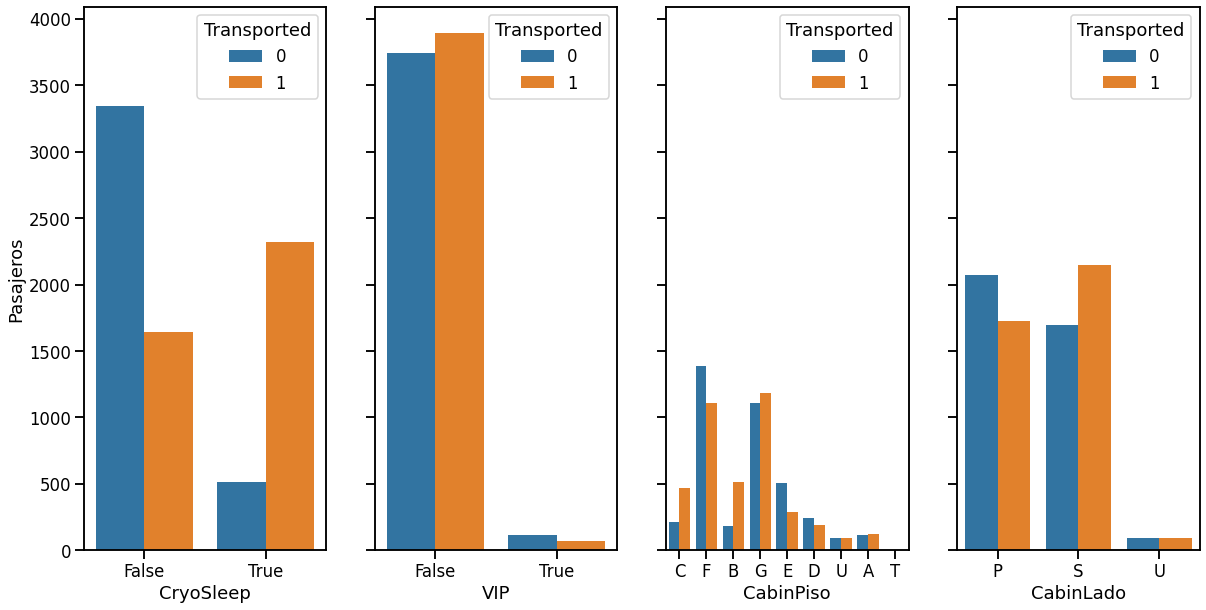

In [15]:
#Graficas de algunas variables categoricas

fig, axes=plt.subplots(1, 4, figsize=(20, 10), sharey=True)
for var, ax in zip(['CryoSleep', 'VIP', 'CabinPiso', 'CabinLado'], axes):
  
  seaborn.countplot(data= train_df, x=var, ax=ax, hue='Transported')
  ax.set_ylabel('Pasajeros')
  if ax != axes[0]:
    ax.set_ylabel('')      

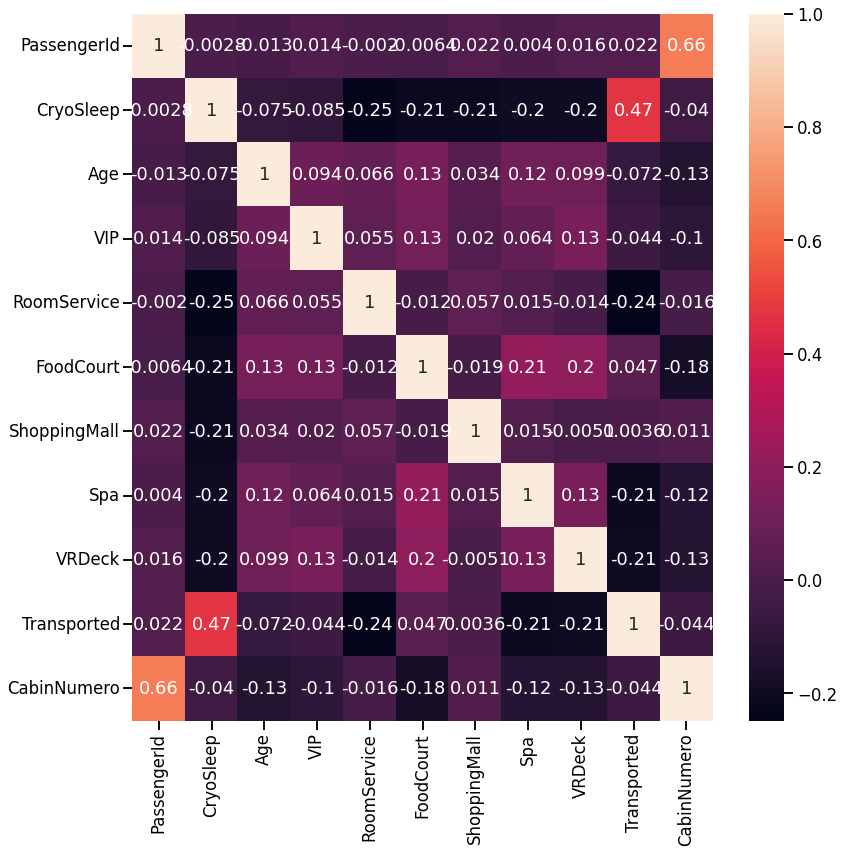

In [16]:
#heatmap para observar relaciones entre variables
fig = plt.figure(figsize=(13,13)) 
corr_df = train_df.corr(method='pearson')
seaborn.heatmap(corr_df, annot=True)

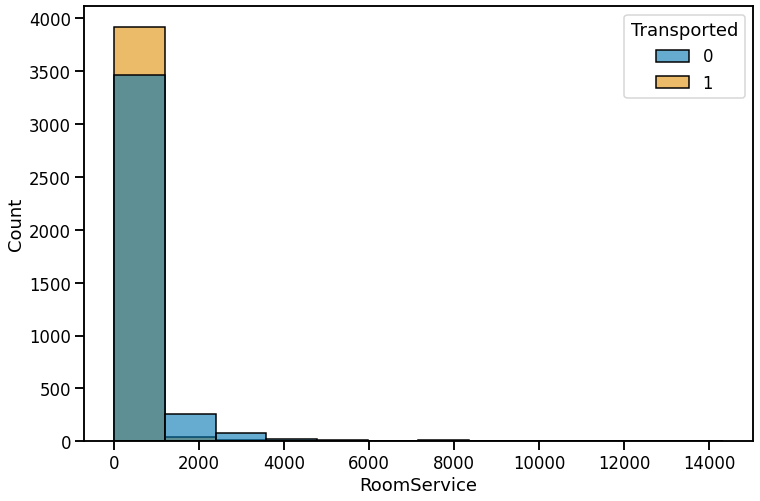

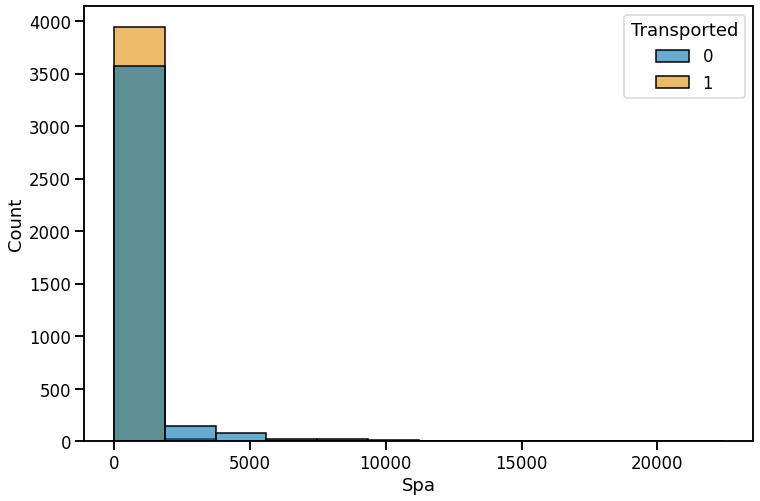

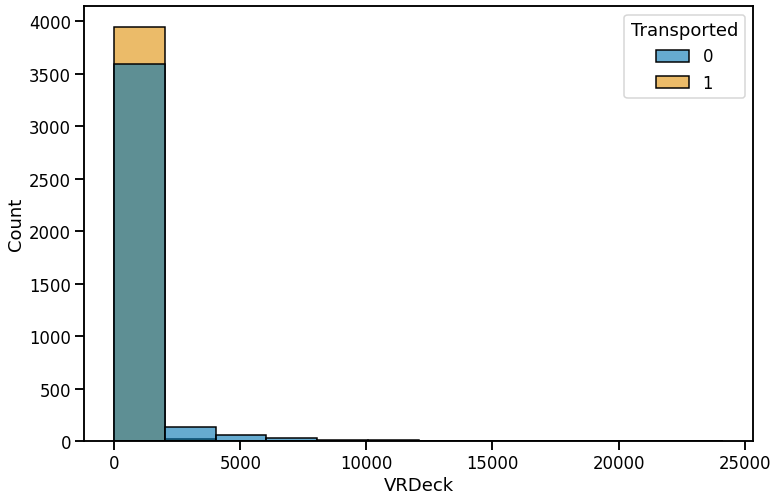

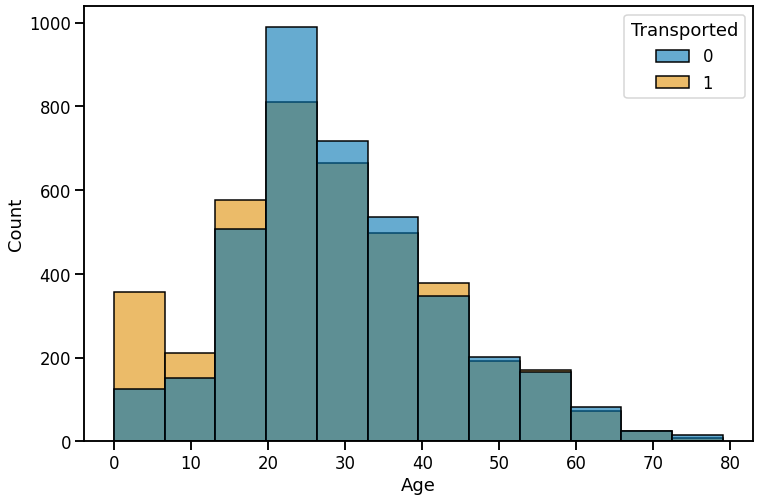

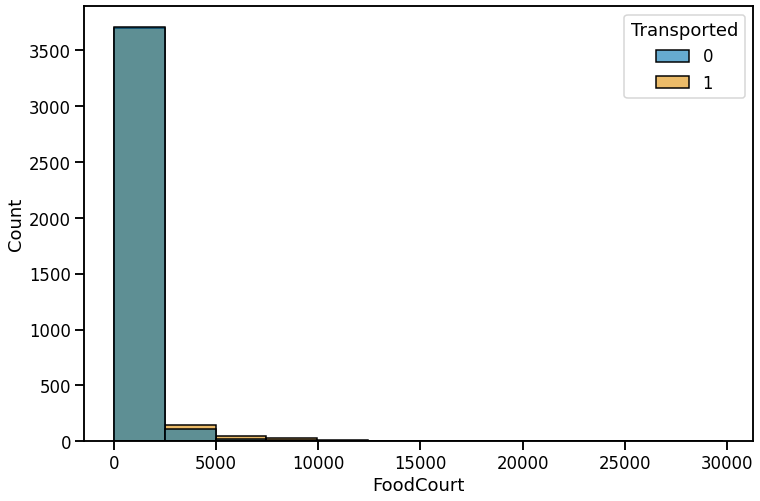

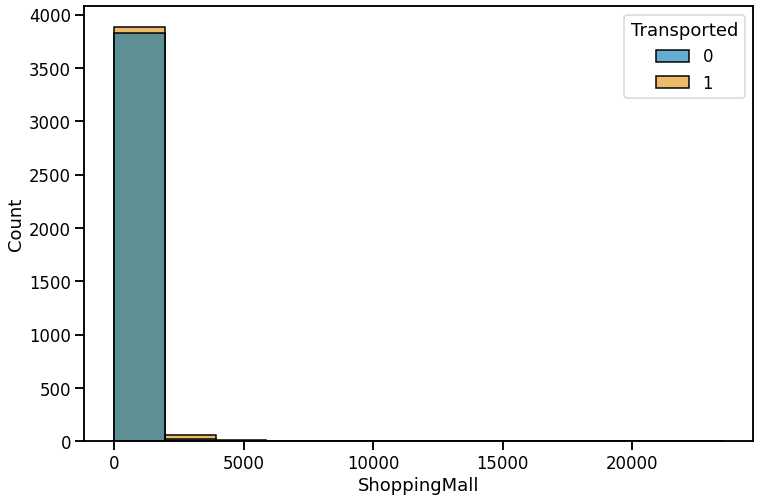

In [42]:
#Histogramas superpuestos para las variables de valores monetarios y edades
variables=['RoomService', 'Spa', 'VRDeck', 'Age', 'FoodCourt', 'ShoppingMall']
for var in variables:
  fig,ax=plt.subplots(figsize=(12,8))
  ax=seaborn.histplot(data=train_df, x=train_df[var], hue='Transported',bins=12, alpha=0.6, palette = "colorblind")
  ax.set_xlabel(var)
plt.show()

En las variables RoomService, Spa y VRDeck, parece haber un aumento en la cantidad de personas transportadas en los valores minimos, esto coincide con la asimetria que existe en la variable CryoSleep, ya que se transportaron la mayoria de los pasajeros que viajan en Cryosueño.

En la variable Edad, se presenta un punto de inflexión alrededor de los 20 años, donde la posibilidad de ser transportado es mayor para los menores de 20.

La variable Lado, de la Cabina no presenta indicios de ningun patron claro, mientras que en el caso de los pisos, las principales asimetrias se dan en las plataformas C, B y E. En cualquiera de las dos variables los datos faltantes que imputamos como desconocidos (U), se dividen equitativamente en Transportados y No Transportados.

# Transformación

In [43]:
pd.options.display.max_columns = None

In [44]:
# Convertimos las variables categoricas CryoSleep, VIP, CabinLado y Transported a valores numericos, ademas nos interesa desdoblar las columnas con variables categoricas, de forma que queeden expresadas en terminos binarios.
def num(t_data):
  X=t_data
  X['CLado']=X['CabinLado'].map({'P':0, 'S':1, 'U':1}) # En la exploración de los datos verificamos que U se distribuye uniformemente, no afectara que lo asignemos a P o S arbitrariamente.
  X[['CryoSleep','VIP']] = X[['CryoSleep','VIP']].astype(int)
  X['CLado']=X['CLado'].fillna(value=0)
  X.drop(labels='CabinLado', axis=1, inplace=True)
  return X

train_df=num(train_df)
test_df=num(test_df)

In [46]:
train_df[['Transported']] = train_df[['Transported']].astype(int) #convertimos a valores enteros (0 o 1)

In [47]:
#Desdoblamiento de la columna Piso, Destination y HomePlanet
def desd(t_data,var,v):
  X=t_data
  Piso = pd.get_dummies(X[var], prefix=v)
  X = pd.concat([X, Piso], axis=1)
  X.drop(labels=var, axis=1, inplace=True)
  return X
train_df=desd(train_df,'CabinPiso','Piso')
test_df=desd(test_df,'CabinPiso','Piso')

train_df=desd(train_df,'Destination','Des')
test_df=desd(test_df,'Destination','Des')

train_df=desd(train_df,'HomePlanet','HP')
test_df=desd(test_df,'HomePlanet','HP')

In [48]:
#Eliminacion de columnas que no vamos a utilizar o ya utilizadas.
train_df = train_df.drop('Transported', axis=1)

train_df=train_df.drop('Name', axis=1)
test_df=test_df.drop('Name', axis=1)

passengerId = test_df.PassengerId #Guardo los Id necesarios para la entrega.
train_df.drop('PassengerId',axis=1,inplace=True)
test_df.drop('PassengerId',axis=1,inplace=True)

train_df.drop('Cabin',axis=1,inplace=True)
test_df.drop('Cabin',axis=1,inplace=True)


In [49]:
test_df.drop('Des_True',axis=1,inplace=True)

In [50]:
#Escalamos las variables no binarias.
def scaler_data(t_data):
  Y=t_data
  Y2=t_data
  label_cols = ["Age", "RoomService", "FoodCourt" ,"ShoppingMall", 'Spa', 'VRDeck', 'CabinNumero']
  scaler=StandardScaler()
  for col in label_cols:
    sp=scaler.fit(Y[col].values.reshape(-1,1))
    Y2[col] = scaler.transform(Y[col].values.reshape(-1,1), sp)
  return Y2
train=scaler_data(train_df)
test=scaler_data(test_df)

In [51]:
#Segmentacion del df en entrenamiento y test
x_train, x_test, y_train, y_test = train_test_split(train, y, train_size=0.8, random_state = 8)

# Modelos

---
Planteamos tres modelos:

## Modelo XGBoost

In [53]:
import xgboost
from xgboost import XGBRegressor, XGBRFRegressor, XGBClassifier, XGBRFClassifier


0.8019169329073482


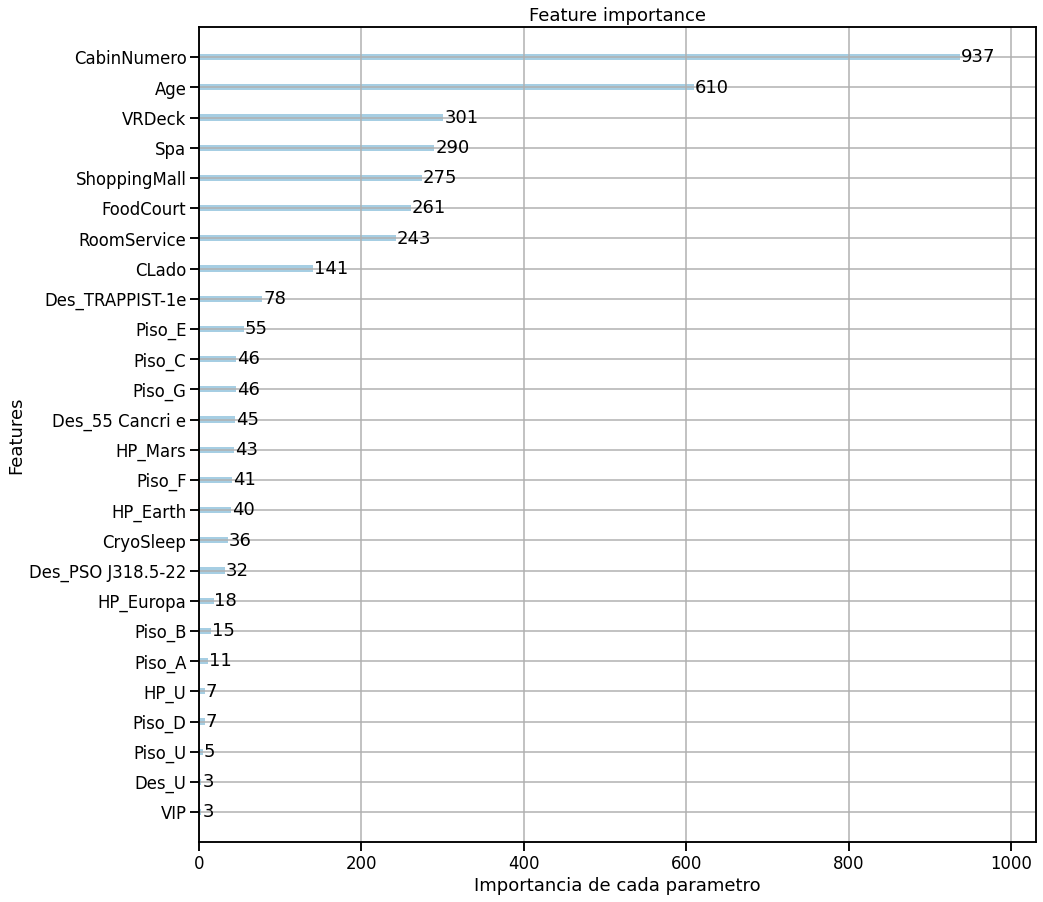

In [54]:
Mod_XGB=xgboost.XGBClassifier(gamma = 1.5, subsample= 0.7, max_depth =9, colsample_bytree=1.0, n_estimators=50, objective='binary:logistic')

#max_depth>9 sobreentrena

Mod_XGB.fit(x_train,y_train)

test_predictions = Mod_XGB.predict(x_test)

accuracy1 = accuracy_score(y_test, test_predictions)

plt.rcParams["figure.figsize"] = (15, 15)
xgboost.plot_importance(Mod_XGB)
plt.xlabel("Importancia de cada parametro")

print(accuracy1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


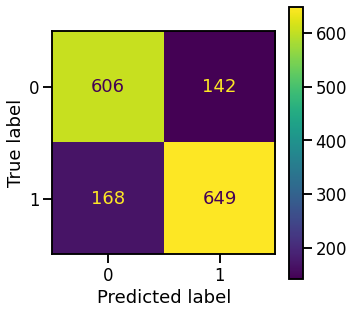

In [55]:
plt.rcParams["figure.figsize"] = (5, 5)
plot_confusion_matrix(Mod_XGB, x_test, y_test)
plt.show()

## Modelo Catboost

In [56]:
!pip install catboost

import catboost
from catboost import CatBoostClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 63 kB/s 


In [59]:
clf_cat = CatBoostClassifier(
    iterations=50, 
    max_depth=9,
    learning_rate=0.05, )

clf_cat.fit(x_train, y_train, 
       verbose=False)

test_predictions_cat = clf_cat.predict(x_test)

accuracy2 = accuracy_score(y_test, test_predictions_cat)
print(accuracy2)

0.8121405750798723


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


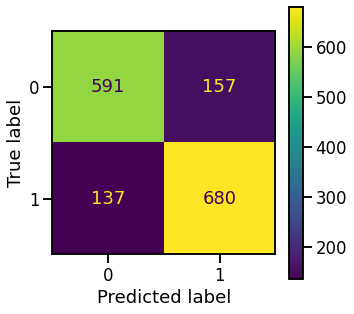

In [60]:
plt.rcParams["figure.figsize"] = (5, 5)
plot_confusion_matrix(clf_cat, x_test, y_test)
plt.show()

## Modelo Random Forest 

In [61]:
from sklearn.ensemble import RandomForestClassifier

In [62]:
clf_random = RandomForestClassifier(n_estimators=10, random_state=2)
clf_random.fit(x_train, y_train)

test_predictions_random = clf_random.predict(x_test)

accuracy3 = accuracy_score(y_test, test_predictions_random)
print(accuracy3)

0.7808306709265176


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


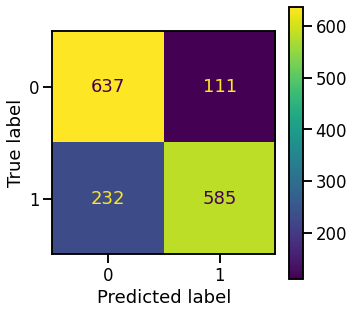

In [63]:
plt.rcParams["figure.figsize"] = (5, 5)
plot_confusion_matrix(clf_random, x_test, y_test)
plt.show()

In [64]:
names = ['Catboost','XGBoost', 'Random Forest']
accuracy_models = [accuracy2, accuracy1, accuracy3]
models = pd.DataFrame({'Model':names, 'Score':accuracy_models})
models.sort_values(by='Score', ascending=False)

,Model,Score
0,Catboost,0.812141
1,XGBoost,0.801917
2,Random Forest,0.780831


# **Conclusión:**

Comparando el accuracy de los distintos modelos planteados, podemos notar que el que mejor prediciria la variable "Transported" es Catboost.


Igualmente comprobamos que a pesar de que en los datos de entrenamiento el modelo Catboost da un accuracy mayor, en los datos de validacion (submission) el XGBoost predice mejor.

# Generamos la salida

In [65]:
test_id = passengerId
test_pred = clf_cat.predict(test)


In [66]:
submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=["PassengerId", "Transported"])
submission.to_csv("sample_submission.csv", header=True, index=False)
submission


,PassengerId,Transported
0,415,1
1,8663,1
2,4524,0
3,8246,0
4,2935,1
...,...,...
865,5996,0
866,5478,1
867,6760,1
868,1437,0
